In [1]:
import gc
import os
import random
import re
import statistics as st
import warnings
from collections import Counter

import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
from gensim.models import Word2Vec
from gensim.test.utils import common_texts
from scipy.stats import kurtosis, skew
from sklearn import metrics, model_selection
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GroupKFold, KFold, StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm.autonotebook import tqdm

/home/rohit/Desktop/kaggle/virtualenvs/writing_quality/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [38]:
class Config:
    INPUT_DIR = "./data"
    seed = 42
    is_time_in_secs = True
    time_divider = 1000 if is_time_in_secs else 1

    num_folds = 10
    num_estimators = 12001
    num_trials_early_stopping = 200

    response_variate = "score"
    use_optuna_tuning = False
    test_size_optuna = 0.3
    num_trials_optuna = 50

    num_features_to_display = 50
    vector_size = 64

In [39]:
cnfg = Config()

In [4]:
tqdm.pandas()
sns.set_style("whitegrid")
warnings.simplefilter("ignore")
random.seed(cnfg.seed)

In [5]:
train_logs = pd.read_csv(f"{cnfg.INPUT_DIR}/train_logs.csv")
train_scores = pd.read_csv(f"{cnfg.INPUT_DIR}/train_scores.csv")
test_logs = pd.read_csv(f"{cnfg.INPUT_DIR}/test_logs.csv")

In [6]:
# sampled_ids = train_logs.id.sample(15).unique()
# train_logs = train_logs[train_logs.id.isin(sampled_ids)].reset_index(drop=True)
# sampled_ids.shape, train_logs.shape

In [7]:
# train_logs

In [8]:
train_logs.columns

Index(['id', 'event_id', 'down_time', 'up_time', 'action_time', 'activity',
       'down_event', 'up_event', 'text_change', 'cursor_position',
       'word_count'],
      dtype='object')

### Utils ###

In [9]:
def my_max(lst):
    try:
        x = max(lst)
    except:
        x = 0
    return x


def my_min(lst):
    try:
        x = min(lst)
    except:
        x = 0
    return x


def my_mean(lst):
    try:
        x = np.mean(lst)
    except:
        x = 0
    return x


def my_std(lst):
    try:
        x = st.stdev(lst)
    except:
        x = 0
    return x


def my_skew(lst):
    try:
        x = skew(lst)
    except:
        x = 0
    return x


def my_kurtosis(lst):
    try:
        x = kurtosis(lst, nan_policy="omit")
    except:
        x = 0
    return x


def my_median_grouped(lst):
    try:
        x = st.median_grouped(lst)
    except:
        x = 0
    return x


def my_sum(lst):
    try:
        x = sum(lst)
    except:
        x = 0
    return x


def q1(x):
    return x.quantile(0.25)


def q3(x):
    return x.quantile(0.75)


def my_kurtosis_series(x):
    k = my_kurtosis(x.values.tolist())
    return k

### Pre-processing ###

In [10]:
from collections import defaultdict


class Preprocessor:
    def __init__(
        self, seed, df, is_test=False, count_vectorizer=None, model_w2vec=None
    ):
        self.seed = seed

        self.is_test = is_test

        self.activities = ["Input", "Remove/Cut", "Nonproduction", "Replace", "Paste"]
        self.activities_name_mapping = {
            "Input": "input",
            "Remove/Cut": "remove",
            "Nonproduction": "non_production",
            "Replace": "replace",
            "Paste": "paste",
        }
        self.text_changes = text_changes = [
            "q",
            " ",
            # "NoChange",
            ".",
            ",",
            "\n",
            "'",
            '"',
            "-",
            "?",
            ";",
            "=",
            "/",
            "\\",
            ":",
        ]
        self.special_character_name_mapping = special_character_name_mapping = {
            "'": "qoute",
            '"': "double_qoute",
            ".": "full_stop",
            ",": "comma",
            "-": "hyphen",
            "?": "question_mark",
            ";": "semi_colon",
            "=": "equal_to",
            "/": "forward_slash",
            "\\": "back_slash",
            ":": "colon",
            "(": "bracket_open",
            ")": "bracket_close",
            "!": "exclamation_mark",
            "[": "square_bracket_open",
            "$": "dollar",
            ">": "greater_than_sign",
            "]": "square_bracket_close",
            "*": "star",
            "%": "percentage",
            "&": "ampresand",
            "<": "less_than_sign",
            "+": "plus_sign",
            "_": "under_score",
            "{": "curly_bracket_open",
            "`": "tilted_qoute",
            "#": "hashtag",
            " ": "blank_space",
            "\n": "new_line_char",
        }
        self.gaps = [1, 2, 3, 5, 10, 20, 50, 100]
        self.df = df.sort_values(["id", "event_id"]).reset_index(drop=True)
        self.AGGREGATIONS = [
            "count",
            "mean",
            "std",
            "min",
            "max",
            "first",
            "last",
            "sem",
            q1,
            "median",
            q3,
            "skew",
            pd.DataFrame.kurt,
            # my_kurtosis_series,
            "sum",
        ]

        if not is_test:
            self.count_vectorizer = CountVectorizer(ngram_range=(1, 2))
        else:
            self.count_vectorizer = count_vectorizer

        if not is_test:
            self.model_w2vec = Word2Vec(
                # sentences=train_sentences,
                vector_size=cnfg.vector_size,
                window=5,
                min_count=1,
                workers=1,
                alpha=0.03,
                seed=cnfg.seed,
                sg=1,
            )
        else:
            self.model_w2vec = model_w2vec

    def remove_lower_categorical_values(self):
        ## Clean activity
        self.df["activity"] = self.df.activity.apply(
            lambda x: x if x in self.activities else "__OUTLIER__"
        )

    def clean_up_time(self):
        """
        For maximum number of ids uptime is not increasing. In each id for one or two events, up_time is incorrectly recorded
        Procedure: Calculate the difference with next if diff is negative replace up_time with the up_time of next.
        """
        print(f"Before uptime cleaning, data shape: {self.df.shape}")
        tmp_df = self.df[["id", "event_id", "up_time"]]
        tmp_df["up_time_next"] = tmp_df.groupby("id").up_time.shift(-1)
        tmp_df["up_time_diff"] = tmp_df["up_time_next"] - tmp_df.up_time

        tmp_df.loc[tmp_df[tmp_df.up_time_diff < 0].index, "up_time"] = tmp_df[
            tmp_df.up_time_diff < 0
        ].up_time_next

        # Do it once more
        tmp_df = tmp_df[["id", "event_id", "up_time"]]
        tmp_df["up_time_next"] = tmp_df.groupby("id").up_time.shift(-1)
        tmp_df["up_time_diff"] = tmp_df["up_time_next"] - tmp_df.up_time
        tmp_df.loc[tmp_df[tmp_df.up_time_diff < 0].index, "up_time"] = tmp_df[
            tmp_df.up_time_diff < 0
        ].up_time_next

        self.df["up_time"] = tmp_df["up_time"]
        print(f"After uptime cleaning, data shape: {self.df.shape}")

    def add_latency_columns(self):
        # HL -> Hold latency, up_time-down_time
        # IL-> Interkey latency -> down_time(event2) - up_time(event1)
        # PL -> Press latency -> down_time(event2)- down_time(event1) or HL+IL
        # RL -> Release Latency -> up_time(event2)- up_time(event1)
        # self.df["HL"] = self.df["up_time"] - self.df["down_time"] #same as action_time
        self.df["IL"] = self.df["down_time"] - self.df.groupby("id").up_time.shift(
            1
        ).fillna(self.df.down_time)
        # self.df["IL"] = self.df["IL"].fillna(0)
        self.df["PL"] = self.df["down_time"] - self.df.groupby("id").down_time.shift(
            1
        ).fillna(self.df.down_time)
        # self.df["PL"] = self.df["PL"].fillna(0)
        self.df["RL"] = self.df["up_time"] - self.df.groupby("id").up_time.shift(
            1
        ).fillna(self.df.up_time)
        # self.df["RL"] = self.df["RL"].fillna(0)

        # self.df = self.df[~self.df.isna().any(axis=1)].reset_index(drop=True)

    def clean_data(self):
        self.remove_lower_categorical_values()
        self.clean_up_time()

        self.add_latency_columns()

    def change_time_columns_to_secs(self):
        time_columns = ["down_time", "up_time", "action_time", "IL", "PL", "RL"]
        for clm in time_columns:
            self.df[clm] = self.df[clm] / cnfg.time_divider

    # Function to construct essays copied from here: https://www.kaggle.com/code/kawaiicoderuwu/essay-contructor
    def getEssays(self):
        textInputDf = self.df[["id", "activity", "cursor_position", "text_change"]]
        textInputDf = textInputDf[textInputDf.activity != "Nonproduction"]
        valCountsArr = textInputDf["id"].value_counts(sort=False).values
        lastIndex = 0
        essaySeries = pd.Series()
        for index, valCount in enumerate(valCountsArr):
            currTextInput = textInputDf[
                ["activity", "cursor_position", "text_change"]
            ].iloc[lastIndex : lastIndex + valCount]
            lastIndex += valCount
            essayText = ""
            for Input in currTextInput.values:
                if Input[0] == "Replace":
                    replaceTxt = Input[2].split(" => ")
                    essayText = (
                        essayText[: Input[1] - len(replaceTxt[1])]
                        + replaceTxt[1]
                        + essayText[
                            Input[1] - len(replaceTxt[1]) + len(replaceTxt[0]) :
                        ]
                    )
                    continue
                if Input[0] == "Paste":
                    essayText = (
                        essayText[: Input[1] - len(Input[2])]
                        + Input[2]
                        + essayText[Input[1] - len(Input[2]) :]
                    )
                    continue
                if Input[0] == "Remove/Cut":
                    essayText = (
                        essayText[: Input[1]] + essayText[Input[1] + len(Input[2]) :]
                    )
                    continue
                if "M" in Input[0]:
                    croppedTxt = Input[0][10:]
                    splitTxt = croppedTxt.split(" To ")
                    valueArr = [item.split(", ") for item in splitTxt]
                    moveData = (
                        int(valueArr[0][0][1:]),
                        int(valueArr[0][1][:-1]),
                        int(valueArr[1][0][1:]),
                        int(valueArr[1][1][:-1]),
                    )
                    if moveData[0] != moveData[2]:
                        if moveData[0] < moveData[2]:
                            essayText = (
                                essayText[: moveData[0]]
                                + essayText[moveData[1] : moveData[3]]
                                + essayText[moveData[0] : moveData[1]]
                                + essayText[moveData[3] :]
                            )
                        else:
                            essayText = (
                                essayText[: moveData[2]]
                                + essayText[moveData[0] : moveData[1]]
                                + essayText[moveData[2] : moveData[0]]
                                + essayText[moveData[1] :]
                            )
                    continue
                essayText = (
                    essayText[: Input[1] - len(Input[2])]
                    + Input[2]
                    + essayText[Input[1] - len(Input[2]) :]
                )
            essaySeries[index] = essayText
        essaySeries.index = textInputDf["id"].unique()

        essay_df = (
            pd.DataFrame(essaySeries, columns=["essay"])
            .reset_index()
            .rename(columns={"index": "id"})
        )

        self.essay_df = essay_df
        return

    def create_tokenisation_features(self, tmp_df):
        X_tokenizer = self.count_vectorizer.transform(self.essay_df["essay"])
        print(f"In tokenisation, X_tokenizer shape: {X_tokenizer.shape}")

        X_tokenizer = np.array(X_tokenizer.todense())
        df_tokenisation = pd.DataFrame(
            X_tokenizer,
            columns=[f"token_feature_{i}" for i in range(X_tokenizer.shape[1])],
        )
        df_tokenisation["id"] = self.essay_df.id
        self.df_tokenisation = df_tokenisation

        tmp_df = tmp_df.merge(df_tokenisation, on="id", how="left")
        return tmp_df

    def get_w2vec_embeddings(self, mdl, sentences, vector_size=64):
        all_embd_final = []
        not_found_words = []
        for i in tqdm(range(len(sentences))):
            all_embd = []
            for j in range(len(sentences[i])):
                try:
                    emb = mdl.wv[sentences[i][j]]
                    all_embd.append(emb)
                except:
                    all_embd.append(np.zeros(vector_size))
                    not_found_words.append(sentences[i][j])
            if all_embd == []:
                embd_final = np.zeros(vector_size)
            else:
                embd_final = np.mean(all_embd, axis=0)
            all_embd_final.append(embd_final)
        embd_df = pd.DataFrame(
            all_embd_final, columns=[f"w2vec_dim_{k}" for k in range(vector_size)]
        )
        return embd_df, not_found_words

    def create_w2vec_features(self, tmp_df):
        sentences = self.essay_df.essay.apply(
            lambda x: [k.strip() for k in x.split(" ") if k != ""]
        )
        if not self.is_test:
            print("==== Training Word2Vec ========")
            self.model_w2vec.build_vocab(sentences, progress_per=10000)
            self.model_w2vec.train(
                sentences,
                total_examples=self.model_w2vec.corpus_count,
                epochs=200,
                report_delay=1,
            )
            print("==== Training Complete ========")

        embd_df, not_found_words_train = self.get_w2vec_embeddings(
            self.model_w2vec, sentences, vector_size=cnfg.vector_size
        )
        embd_df["id"] = self.essay_df.id
        tmp_df = tmp_df.merge(embd_df, on="id", how="left")
        return tmp_df

    def split_essays_into_sentences(self):
        essay_df = self.essay_df
        essay_df["sent"] = essay_df["essay"].apply(lambda x: re.split("\\.|\\?|\\!", x))
        essay_df = essay_df.explode("sent")
        essay_df["sent"] = essay_df["sent"].apply(lambda x: x.replace("\n", "").strip())
        # Number of characters in sentences
        essay_df["sent_len"] = essay_df["sent"].apply(lambda x: len(x))
        # Number of words in sentences
        essay_df["sent_word_count"] = essay_df["sent"].apply(
            lambda x: len(x.split(" "))
        )
        essay_df = essay_df[essay_df.sent_len != 0].reset_index(drop=True)
        self.sent_df = essay_df
        return

    def split_essays_into_paragraphs(self):
        essay_df = self.essay_df
        essay_df["paragraph"] = essay_df["essay"].apply(lambda x: x.split("\n"))
        essay_df = essay_df.explode("paragraph")
        # Number of characters in paragraphs
        essay_df["paragraph_len"] = essay_df["paragraph"].apply(lambda x: len(x))
        # Number of words in paragraphs
        essay_df["paragraph_word_count"] = essay_df["paragraph"].apply(
            lambda x: len(x.split(" "))
        )
        essay_df = essay_df[essay_df.paragraph_len != 0].reset_index(drop=True)

        self.para_df = essay_df
        return

    def compute_sentence_aggregations(self, tmp_df):
        sent_agg_df = pd.concat(
            [
                self.sent_df[["id", "sent_len"]].groupby(["id"]).agg(self.AGGREGATIONS),
                self.sent_df[["id", "sent_word_count"]]
                .groupby(["id"])
                .agg(self.AGGREGATIONS),
            ],
            axis=1,
        )
        sent_agg_df.columns = ["_".join(x) for x in sent_agg_df.columns]
        sent_agg_df["id"] = sent_agg_df.index
        sent_agg_df = sent_agg_df.reset_index(drop=True)
        sent_agg_df.drop(columns=["sent_word_count_count"], inplace=True)
        sent_agg_df = sent_agg_df.rename(columns={"sent_len_count": "sent_count"})

        sent_agg_df = sent_agg_df.fillna(-1111)

        tmp_df = tmp_df.merge(sent_agg_df, on="id", how="left")
        return tmp_df

    def compute_paragraph_aggregations(self, tmp_df):
        paragraph_agg_df = pd.concat(
            [
                self.para_df[["id", "paragraph_len"]]
                .groupby(["id"])
                .agg(self.AGGREGATIONS),
                self.para_df[["id", "paragraph_word_count"]]
                .groupby(["id"])
                .agg(self.AGGREGATIONS),
            ],
            axis=1,
        )
        paragraph_agg_df.columns = ["_".join(x) for x in paragraph_agg_df.columns]
        paragraph_agg_df["id"] = paragraph_agg_df.index
        paragraph_agg_df = paragraph_agg_df.reset_index(drop=True)
        paragraph_agg_df.drop(columns=["paragraph_word_count_count"], inplace=True)
        paragraph_agg_df = paragraph_agg_df.rename(
            columns={"paragraph_len_count": "paragraph_count"}
        )
        paragraph_agg_df = paragraph_agg_df.fillna(-1111)
        tmp_df = tmp_df.merge(paragraph_agg_df, on="id", how="left")
        return tmp_df

    def activity_features(self, tmp_df):
        # Activity Counts to total activity count ratio
        # Number of different activities
        features_to_drop = []
        ret = list()
        for i, li in tqdm(enumerate(tmp_df["activity_list"].values)):
            items = list(Counter(li).items())
            di = dict()
            for k in self.activities_name_mapping.keys():
                di[self.activities_name_mapping[k]] = 0
            for item in items:
                k, v = item[0], item[1]
                if k in self.activities_name_mapping.keys():
                    # if self.activities_name_mapping[k] in di:
                    di[self.activities_name_mapping[k]] = v
            ret.append(di)
        ret = pd.DataFrame(ret)
        cols = [f"activity_{act_name}_count" for act_name in ret.columns]
        ret.columns = cols

        # If using ratios drop count columns
        features_to_drop.extend(cols)

        tmp_df = pd.concat([tmp_df, ret], axis=1)
        ###############################################################################
        # Ratios to total activity
        for act_clm in self.activities_name_mapping.values():
            tmp_df[f"activity_{act_clm}_ratio_total"] = (
                tmp_df[f"activity_{act_clm}_count"] / tmp_df["total_num_activites"]
            )
        ###############################################################################
        # Ratio to "Input" Activity
        for act_clm in self.activities_name_mapping.values():
            if act_clm != "input":
                tmp_df[f"activity_{act_clm}_ratio_input"] = (
                    tmp_df[f"activity_{act_clm}_count"] / tmp_df["activity_input_count"]
                )
        ###############################################################################
        # Ratio to "Nonproduction"
        for act_clm in self.activities_name_mapping.values():
            if act_clm != "non_production":
                tmp_df[f"activity_{act_clm}_ratio_non_production"] = (
                    tmp_df[f"activity_{act_clm}_count"]
                    / tmp_df["activity_non_production_count"]
                )
        ###############################################################################
        # Ratio of first occurence of each activity to total_time taken
        for act_clm in self.activities_name_mapping.keys():
            first_occr_df = self.df[self.df.activity == act_clm].drop_duplicates(
                subset=["id", "activity"], keep="first"
            )
            first_occr_df[
                f"{self.activities_name_mapping[act_clm]}_first_time"
            ] = first_occr_df["down_time"]
            first_occr_df = first_occr_df[
                ["id", f"{self.activities_name_mapping[act_clm]}_first_time"]
            ]
            tmp_df = tmp_df.merge(first_occr_df, on="id", how="left")
            tmp_df[f"{self.activities_name_mapping[act_clm]}_first_time"] = (
                tmp_df[f"{self.activities_name_mapping[act_clm]}_first_time"]
                - tmp_df["start_time"]
            )
            tmp_df[
                f"{self.activities_name_mapping[act_clm]}_first_time_total_ratio"
            ] = (
                tmp_df[f"{self.activities_name_mapping[act_clm]}_first_time"]
                / tmp_df["total_time_taken"]
            )

            tmp_df[
                f"{self.activities_name_mapping[act_clm]}_first_time_total_ratio"
            ] = tmp_df[
                f"{self.activities_name_mapping[act_clm]}_first_time_total_ratio"
            ].fillna(
                -1
            )

            features_to_drop.append(
                f"{self.activities_name_mapping[act_clm]}_first_time"
            )
        ###############################################################################
        # Ratio of last occurence of each activity to total_time taken
        for act_clm in self.activities_name_mapping.keys():
            last_occr_df = self.df[self.df.activity == act_clm].drop_duplicates(
                subset=["id", "activity"], keep="last"
            )
            last_occr_df[
                f"{self.activities_name_mapping[act_clm]}_last_time"
            ] = last_occr_df["down_time"]
            last_occr_df = last_occr_df[
                ["id", f"{self.activities_name_mapping[act_clm]}_last_time"]
            ]
            tmp_df = tmp_df.merge(last_occr_df, on="id", how="left")
            tmp_df[f"{self.activities_name_mapping[act_clm]}_last_time"] = (
                tmp_df[f"{self.activities_name_mapping[act_clm]}_last_time"]
                - tmp_df["start_time"]
            )
            tmp_df[f"{self.activities_name_mapping[act_clm]}_last_time_total_ratio"] = (
                tmp_df[f"{self.activities_name_mapping[act_clm]}_last_time"]
                / tmp_df["total_time_taken"]
            )

            tmp_df[
                f"{self.activities_name_mapping[act_clm]}_last_time_total_ratio"
            ] = tmp_df[
                f"{self.activities_name_mapping[act_clm]}_last_time_total_ratio"
            ].fillna(
                -1
            )

            features_to_drop.append(
                f"{self.activities_name_mapping[act_clm]}_last_time"
            )

        ###############################################################################
        # min max mean std and other stats values of time between each type of activity
        methods_to_apply = [
            my_min,
            my_max,
            my_mean,
            my_std,
            my_skew,
            # my_kurtosis,
            pd.DataFrame.kurt,
            my_median_grouped,
        ]

        for act_clm in ["Input", "Remove/Cut", "Nonproduction"]:
            particular_act_df = self.df[self.df.activity == act_clm].reset_index(
                drop=True
            )
            act_clm = self.activities_name_mapping[act_clm]
            particular_act_df[f"{act_clm}_prev_event_time"] = particular_act_df.groupby(
                "id"
            ).down_time.shift(1)
            particular_act_df[f"{act_clm}_inter_act_latency"] = (
                particular_act_df["down_time"]
                - particular_act_df[f"{act_clm}_prev_event_time"]
            )

            particular_act_df[f"{act_clm}_inter_act_latency"] = particular_act_df[
                f"{act_clm}_inter_act_latency"
            ].fillna(0)

            # particular_act_df = particular_act_df[
            #     ~particular_act_df.isna().any(axis=1)
            # ].reset_index(drop=True)

            colname = f"{act_clm}_inter_act_latency"
            for method in methods_to_apply:
                if isinstance(method, str):
                    method_name = method
                else:
                    method_name = method.__name__
                colname_method = f"{act_clm}_{method_name}_inter_act_latency"
                tmp2_df = (
                    particular_act_df.groupby(["id"])
                    .agg({colname: method})
                    .reset_index()
                    .rename(columns={colname: colname_method})
                )

                tmp_df = tmp_df.merge(tmp2_df, on="id", how="left")
                tmp_df[colname_method] = tmp_df[colname_method].fillna(0)

        ###############################################################################
        # Number of type of down_events in each of ["Input", "Remove/Cut", "Nonproduction"]
        for act_clm in ["Input", "Remove/Cut", "Nonproduction"]:
            particular_act_df = self.df[self.df.activity == act_clm].reset_index(
                drop=True
            )
            act_clm = self.activities_name_mapping[act_clm]
            colname = f"num_type_down_events_in_{act_clm}"
            tmp2_df = (
                particular_act_df.groupby("id", as_index=False)
                .agg({"down_event": "nunique"})
                .rename(columns={"down_event": colname})
            )
            tmp_df = tmp_df.merge(tmp2_df, on="id", how="left")
            tmp_df[colname] = tmp_df[colname].fillna(0)

        ###############################################################################
        ## Ways in which remove/cut happens -> Top ways -> ['Backspace','Delete','x','z','Rightclick'] ratios
        remove_df = self.df[self.df.activity == "Remove/Cut"].reset_index(drop=True)
        name_for_remove = self.activities_name_mapping["Remove/Cut"]
        remove_feats_df = remove_df.groupby("id", as_index=False).agg(
            total_remove_activity=("down_event", lambda x: len(list(x)))
        )
        tmp_df = tmp_df.merge(remove_feats_df, on="id", how="left")

        features_to_drop.append("total_remove_activity")  # Remove this column

        for dwn_evnt in ["Backspace", "Delete", "x", "z", "Rightclick"]:
            colname = f"{dwn_evnt}_in_{name_for_remove}_share"
            tmp2_df = (
                remove_df[remove_df.down_event == dwn_evnt]
                .groupby("id", as_index=False)
                .agg({"down_event": lambda x: len(list(x))})
                .rename(columns={"down_event": colname})
            )
            tmp_df = tmp_df.merge(tmp2_df, on="id", how="left")
            tmp_df[colname] = tmp_df[colname].fillna(0)
        # Normalise
        for dwn_evnt in ["Backspace", "Delete", "x", "z", "Rightclick"]:
            colname = f"{dwn_evnt}_in_{name_for_remove}_share"
            tmp_df[colname] = tmp_df[colname] / tmp_df["total_remove_activity"]
            tmp_df[colname] = tmp_df[colname].fillna(0)

        ###############################################################################
        ## Ways in which replace happens -> Top ways -> ['q','Space','.',',','z','v','Enter','Rightclick'] ratios
        replace_df = self.df[self.df.activity == "Replace"].reset_index(drop=True)
        name_for_replace = self.activities_name_mapping["Replace"]
        replace_feats_df = replace_df.groupby("id", as_index=False).agg(
            total_replace_activity=("down_event", lambda x: len(list(x)))
        )
        tmp_df = tmp_df.merge(replace_feats_df, on="id", how="left")

        features_to_drop.append("total_replace_activity")  # Remove this column

        for dwn_evnt in ["q", "Space", ".", ",", "z", "v", "Enter", "Rightclick"]:
            dwn_evnt_name = (
                dwn_evnt
                if dwn_evnt not in self.special_character_name_mapping.keys()
                else self.special_character_name_mapping[dwn_evnt]
            )
            colname = f"{dwn_evnt_name}_in_{name_for_replace}_share"
            tmp2_df = (
                replace_df[replace_df.down_event == dwn_evnt]
                .groupby("id", as_index=False)
                .agg({"down_event": lambda x: len(list(x))})
                .rename(columns={"down_event": colname})
            )
            tmp_df = tmp_df.merge(tmp2_df, on="id", how="left")
            tmp_df[colname] = tmp_df[colname].fillna(0)
        # Normalise
        for dwn_evnt in ["q", "Space", ".", ",", "z", "v", "Enter", "Rightclick"]:
            dwn_evnt_name = (
                dwn_evnt
                if dwn_evnt not in self.special_character_name_mapping.keys()
                else self.special_character_name_mapping[dwn_evnt]
            )
            colname = f"{dwn_evnt_name}_in_{name_for_replace}_share"
            tmp_df[colname] = tmp_df[colname] / tmp_df["total_replace_activity"]
            tmp_df[colname] = tmp_df[colname].fillna(0)

        ###############################################################################
        """
        Ways in which Nonproduction happens -> Top ways ->  top_ways_np ratios
        """
        top_ways_np = [
            "Shift",
            "ArrowRight",
            "Leftclick",
            "ArrowLeft",
            "ArrowDown",
            "ArrowUp",
            "CapsLock",
            "Control",
            "Backspace",
            "Tab",
            "ContextMenu",
            "End",
            "Rightclick",
        ]
        np_df = self.df[self.df.activity == "Nonproduction"].reset_index(drop=True)
        name_for_np = self.activities_name_mapping["Nonproduction"]
        np_feats_df = np_df.groupby("id", as_index=False).agg(
            total_np_activity=("down_event", lambda x: len(list(x)))
        )
        tmp_df = tmp_df.merge(np_feats_df, on="id", how="left")

        features_to_drop.append("total_np_activity")  # Remove this column

        for dwn_evnt in top_ways_np:
            dwn_evnt_name = (
                dwn_evnt
                if dwn_evnt not in self.special_character_name_mapping.keys()
                else self.special_character_name_mapping[dwn_evnt]
            )
            colname = f"{dwn_evnt_name}_in_{name_for_np}_share"
            tmp2_df = (
                np_df[np_df.down_event == dwn_evnt]
                .groupby("id", as_index=False)
                .agg({"down_event": lambda x: len(list(x))})
                .rename(columns={"down_event": colname})
            )
            tmp_df = tmp_df.merge(tmp2_df, on="id", how="left")
            tmp_df[colname] = tmp_df[colname].fillna(0)
        # Normalise
        for dwn_evnt in top_ways_np:
            dwn_evnt_name = (
                dwn_evnt
                if dwn_evnt not in self.special_character_name_mapping.keys()
                else self.special_character_name_mapping[dwn_evnt]
            )
            colname = f"{dwn_evnt_name}_in_{name_for_np}_share"
            tmp_df[colname] = tmp_df[colname] / tmp_df["total_np_activity"]
            tmp_df[colname] = tmp_df[colname].fillna(0)

        ###############################################################################
        """
        Ways in which Input happens -> Top ways ->  top_ways_np ratios
        """
        top_ways_input = [
            "q",
            "Space",
            "Enter",
        ] + list(self.special_character_name_mapping.keys())

        top_ways_input = [
            inp
            for inp in top_ways_input
            if inp
            not in [
                ":",
                "(",
                ")",
                "!",
                "[",
                "$",
                ">",
                "]",
                "*",
                "%",
                "&",
                "<",
                "+",
                "_",
                "{",
                "`",
                "#",
                " ",
                "\n",
            ]
        ]
        input_df = self.df[self.df.activity == "Input"].reset_index(drop=True)
        name_for_input = self.activities_name_mapping["Input"]
        input_feats_df = input_df.groupby("id", as_index=False).agg(
            total_input_activity=("down_event", lambda x: len(list(x)))
        )
        tmp_df = tmp_df.merge(input_feats_df, on="id", how="left")

        features_to_drop.append("total_input_activity")  # Remove this column

        for dwn_evnt in top_ways_input:
            dwn_evnt_name = (
                dwn_evnt
                if dwn_evnt not in self.special_character_name_mapping.keys()
                else self.special_character_name_mapping[dwn_evnt]
            )
            colname = f"{dwn_evnt_name}_in_{name_for_input}_share"
            tmp2_df = (
                input_df[input_df.down_event == dwn_evnt]
                .groupby("id", as_index=False)
                .agg({"down_event": lambda x: len(list(x))})
                .rename(columns={"down_event": colname})
            )
            tmp_df = tmp_df.merge(tmp2_df, on="id", how="left")
            tmp_df[colname] = tmp_df[colname].fillna(0)
        # Normalise
        for dwn_evnt in top_ways_input:
            dwn_evnt_name = (
                dwn_evnt
                if dwn_evnt not in self.special_character_name_mapping.keys()
                else self.special_character_name_mapping[dwn_evnt]
            )
            colname = f"{dwn_evnt_name}_in_{name_for_input}_share"
            tmp_df[colname] = tmp_df[colname] / tmp_df["total_input_activity"]
            tmp_df[colname] = tmp_df[colname].fillna(0)

        ###############################################################################

        ###############################################################################
        print(f"Features dropping in activity function {features_to_drop}")
        tmp_df = tmp_df.drop(columns=features_to_drop)
        return tmp_df

    def word_count_features(self, tmp_df):
        word_count_df = self.df[["id", "event_id", "word_count", "down_time"]]
        # Number of times words deleted:
        word_count_df["word_count_first_derivative"] = word_count_df[
            "word_count"
        ] - word_count_df.groupby("id").word_count.shift(1)

        word_count_df["word_count_first_derivative"] = word_count_df[
            "word_count_first_derivative"
        ].fillna(0)
        # word_count_df = word_count_df[~word_count_df.isna().any(axis=1)].reset_index(
        #     drop=True
        # )

        wc_feats_df = word_count_df.groupby("id", as_index=False).agg(
            num_times_word_deleted=(
                "word_count_first_derivative",
                lambda x: my_sum([1 for i in list(x) if i < 0]),
            ),
            num_words_deleted=(  # take ratio with total words
                "word_count_first_derivative",
                lambda x: my_sum([-i for i in list(x) if i < 0]),
            ),
            size_of_biggest_chunk_removed=(  # take ratio with total words
                "word_count_first_derivative",
                lambda x: my_max([-i for i in list(x) if i < 0]),
            ),
            avg_num_words_removed_at_a_time=(  # take ratio with total words
                "word_count_first_derivative",
                lambda x: my_mean([-i for i in list(x) if i < 0]),
            ),
        )
        wc_feats_df = wc_feats_df.fillna(0)
        tmp_df = tmp_df.merge(wc_feats_df, on="id", how="left")
        tmp_df["num_words_deleted"] = (
            tmp_df["num_words_deleted"] / tmp_df["total_word_count"]
        )
        tmp_df["num_words_deleted"] = tmp_df["num_words_deleted"].fillna(0)

        tmp_df["size_of_biggest_chunk_removed"] = (
            tmp_df["size_of_biggest_chunk_removed"] / tmp_df["total_word_count"]
        )
        tmp_df["size_of_biggest_chunk_removed"] = tmp_df[
            "size_of_biggest_chunk_removed"
        ].fillna(0)

        tmp_df["avg_num_words_removed_at_a_time"] = (
            tmp_df["avg_num_words_removed_at_a_time"] / tmp_df["total_word_count"]
        )
        tmp_df["avg_num_words_removed_at_a_time"] = tmp_df[
            "avg_num_words_removed_at_a_time"
        ].fillna(0)

        word_count_df2 = word_count_df[
            word_count_df.word_count_first_derivative < 0
        ].reset_index(drop=True)
        word_count_df2 = word_count_df2.merge(
            tmp_df[["id", "start_time", "total_time_taken"]], on="id"
        )
        word_count_df2["time_for_word_deletion_share"] = (
            word_count_df2["down_time"] - word_count_df2["start_time"]
        )
        word_count_df2["time_for_word_deletion_share"] = (
            word_count_df2["time_for_word_deletion_share"]
            / word_count_df2["total_time_taken"]
        )

        # Time after start when word is deleted first time and last time
        wc_feats_df = word_count_df2.groupby("id", as_index=False).agg(
            first_time_word_deletion=(
                "time_for_word_deletion_share",
                lambda x: list(x)[0],
            ),
            last_time_word_deletion=(
                "time_for_word_deletion_share",
                lambda x: list(x)[-1],
            ),
        )
        wc_feats_df = wc_feats_df.fillna(0)
        tmp_df = tmp_df.merge(wc_feats_df, on="id", how="left")
        tmp_df["first_time_word_deletion"] = tmp_df["first_time_word_deletion"].fillna(
            0
        )
        tmp_df["last_time_word_deletion"] = tmp_df["last_time_word_deletion"].fillna(0)

        # Average,max,min,std of time between word deletions
        word_count_df2["time_between_word_deletions"] = word_count_df2[
            "down_time"
        ] - word_count_df2.groupby("id").down_time.shift(1)
        word_count_df2["time_between_word_deletions"] = word_count_df2[
            "time_between_word_deletions"
        ].fillna(0)
        # word_count_df2 = word_count_df2[~word_count_df2.isna().any(axis=1)].reset_index(
        #     drop=True
        # )

        wc_feats_df = word_count_df2.groupby("id", as_index=False).agg(
            mean_time_btw_word_deletions=(
                "time_between_word_deletions",
                lambda x: my_mean(list(x)),
            ),
            max_time_btw_word_deletions=(
                "time_between_word_deletions",
                lambda x: my_max(list(x)),
            ),
            min_time_btw_word_deletions=(
                "time_between_word_deletions",
                lambda x: my_min(list(x)),
            ),
            std_time_btw_word_deletions=(
                "time_between_word_deletions",
                lambda x: my_std(list(x)),
            ),
        )

        wc_feats_df = wc_feats_df.fillna(0)
        tmp_df = tmp_df.merge(wc_feats_df, on="id", how="left")
        tmp_df["mean_time_btw_word_deletions"] = (
            tmp_df["mean_time_btw_word_deletions"] / tmp_df["total_time_taken"]
        )
        tmp_df["mean_time_btw_word_deletions"] = tmp_df[
            "mean_time_btw_word_deletions"
        ].fillna(0)

        tmp_df["max_time_btw_word_deletions"] = (
            tmp_df["max_time_btw_word_deletions"] / tmp_df["total_time_taken"]
        )
        tmp_df["max_time_btw_word_deletions"] = tmp_df[
            "max_time_btw_word_deletions"
        ].fillna(0)

        tmp_df["min_time_btw_word_deletions"] = (
            tmp_df["min_time_btw_word_deletions"] / tmp_df["total_time_taken"]
        )
        tmp_df["min_time_btw_word_deletions"] = tmp_df[
            "min_time_btw_word_deletions"
        ].fillna(0)

        tmp_df["std_time_btw_word_deletions"] = (
            tmp_df["std_time_btw_word_deletions"] / tmp_df["total_time_taken"]
        )
        tmp_df["std_time_btw_word_deletions"] = tmp_df[
            "std_time_btw_word_deletions"
        ].fillna(0)

        return tmp_df

    def cursor_position_features(self, tmp_df):
        cursor_pos_df = self.df[["id", "event_id", "cursor_position", "down_time"]]
        # Number of times cursor position is decreased means gone back to see something:
        cursor_pos_df["cursor_pos_first_derivative"] = cursor_pos_df[
            "cursor_position"
        ] - cursor_pos_df.groupby("id").cursor_position.shift(1)
        cursor_pos_df["cursor_pos_first_derivative"] = cursor_pos_df[
            "cursor_pos_first_derivative"
        ].fillna(0)
        # cursor_pos_df = cursor_pos_df[~cursor_pos_df.isna().any(axis=1)].reset_index(
        #     drop=True
        # )

        cp_feats_df = cursor_pos_df.groupby("id", as_index=False).agg(
            num_times_cp_decreased=(
                "cursor_pos_first_derivative",
                lambda x: my_sum([1 for i in list(x) if i < 0]),
            ),
            size_of_biggest_cp_decreased=(
                "cursor_pos_first_derivative",
                lambda x: my_max([-i for i in list(x) if i < 0]),
            ),
            avg_size_of_cp_decreased_at_a_time=(
                "cursor_pos_first_derivative",
                lambda x: my_mean([-i for i in list(x) if i < 0]),
            ),
        )
        cp_feats_df = cp_feats_df.fillna(0)
        tmp_df = tmp_df.merge(cp_feats_df, on="id", how="left")

        return tmp_df

    def text_change_features(self, tmp_df):
        # Count of all text_change features
        for txt_chng in self.text_changes:
            txt_chng_name = (
                txt_chng
                if txt_chng not in self.special_character_name_mapping.keys()
                else self.special_character_name_mapping[txt_chng]
            )

            text_change_df = self.df[self.df.text_change == txt_chng]
            cnt_col_name = f"{txt_chng_name}_tc_total_share"
            text_change_features = (
                text_change_df.groupby("id", as_index=False)
                .agg({"text_change": lambda x: len(list(x))})
                .rename(columns={"text_change": cnt_col_name})
            )
            tmp_df = tmp_df.merge(text_change_features, on="id", how="left")
            tmp_df[cnt_col_name] = tmp_df[cnt_col_name].fillna(0)
            ## Ratio of text_change in particular activity
            for act in ["Input", "Remove/Cut"]:
                act_name = self.activities_name_mapping[act]
                cnt_col_name2 = f"{txt_chng_name}_in_{act_name}_tc_total_share"
                text_change_df2 = text_change_df[text_change_df.activity == act]
                text_change_features2 = (
                    text_change_df2.groupby("id", as_index=False)
                    .agg({"text_change": lambda x: len(list(x))})
                    .rename(columns={"text_change": cnt_col_name2})
                )

                tmp_df = tmp_df.merge(text_change_features2, on="id", how="left")
                tmp_df[cnt_col_name2] = tmp_df[cnt_col_name2].fillna(0)
                # Normalise
                tmp_df[cnt_col_name2] = tmp_df[cnt_col_name2] / tmp_df[cnt_col_name]
                tmp_df[cnt_col_name2] = tmp_df[cnt_col_name2].fillna(0)

            # Normalise count of text change type with total event count
            tmp_df[cnt_col_name] = tmp_df[cnt_col_name] / tmp_df["num_events"]
            tmp_df[cnt_col_name] = tmp_df[cnt_col_name].fillna(0)

        return tmp_df

    def word_len_features(self, tmp_df):
        essay_text_df = self.df[
            (~self.df["text_change"].str.contains("=>"))
            & (self.df["text_change"] != "NoChange")
        ].reset_index(drop=True)
        essay_text_df = (
            essay_text_df.groupby("id").agg({"text_change": list}).reset_index()
        )
        essay_text_df["text_change"] = essay_text_df["text_change"].apply(
            lambda x: "".join(x)
        )
        essay_text_df["text_change2"] = essay_text_df["text_change"].apply(
            lambda x: re.findall(r"q+", x)
        )
        essay_text_df["input_word_count"] = essay_text_df["text_change2"].apply(len)
        essay_text_df["input_word_length_mean"] = essay_text_df["text_change2"].apply(
            lambda x: np.mean([len(i) for i in x] if len(x) > 0 else 0)
        )
        essay_text_df["input_word_length_max"] = essay_text_df["text_change2"].apply(
            lambda x: np.max([len(i) for i in x] if len(x) > 0 else 0)
        )
        essay_text_df["input_word_length_std"] = essay_text_df["text_change2"].apply(
            lambda x: np.std([len(i) for i in x] if len(x) > 0 else 0)
        )

        essay_text_df["input_word_length_skew"] = essay_text_df["text_change2"].apply(
            lambda x: my_skew([len(i) for i in x] if len(x) > 0 else 0)
        )

        essay_text_df["input_word_length_kurtosis"] = essay_text_df[
            "text_change2"
        ].apply(lambda x: my_kurtosis([len(i) for i in x] if len(x) > 0 else 0))

        essay_text_df2 = essay_text_df[["id", "text_change2"]].explode(
            column="text_change2"
        )
        essay_text_df2 = essay_text_df2.dropna().reset_index(drop=True)

        essay_text_df = essay_text_df.drop(columns=["text_change", "text_change2"])

        tmp_df = tmp_df.merge(essay_text_df, on="id", how="left")

        ## Count number of words of lengths ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', 'more_than_10']
        essay_text_df2["word_len"] = essay_text_df2.text_change2.apply(
            lambda x: "more_than_10" if len(x) > 10 else str(len(x))
        )

        essay_text_df2 = essay_text_df2.groupby("id", as_index=False).agg(
            {"word_len": list}
        )
        list_of_word_lens = [
            "1",
            "2",
            "3",
            "4",
            "5",
            "6",
            "7",
            "8",
            "9",
            "10",
            "more_than_10",
        ]
        ret = list()
        for li in tqdm(essay_text_df2["word_len"].values):
            items = list(Counter(li).items())
            di = dict()
            for k in list_of_word_lens:
                di[k] = 0
            for item in items:
                k, v = item[0], item[1]
                if k in di:
                    di[k] = v
            ret.append(di)
        ret = pd.DataFrame(ret)
        cols = [f"words_of_len_{i}_share" for i in ret.columns]
        ret.columns = cols
        tmp_df = pd.concat([tmp_df, ret], axis=1)
        # Normalise
        for word_len in list_of_word_lens:
            colname = f"words_of_len_{word_len}_share"
            tmp_df[colname] = tmp_df[colname] / tmp_df["input_word_count"]

        return tmp_df

    def get_stats_for_different_features(self, tmp_df):
        methods_to_apply = [
            # my_min,
            my_max,
            my_mean,
            my_std,
            my_skew,
            # my_kurtosis,
            pd.DataFrame.kurt,
            my_median_grouped,
            "last",
            "first",
            "sem",
            # "median",
            "sum",
        ]
        clms_for_stats = [
            # "down_time",
            # "up_time",
            "action_time",
            "cursor_position",
            "word_count",
            "IL",
            "PL",
        ]

        for clm in clms_for_stats:
            colname = f"{clm}_stats"
            for method in methods_to_apply:
                if isinstance(method, str):
                    method_name = method
                else:
                    method_name = method.__name__
                colname_method = f"{colname}_{method_name}"
                tmp2_df = (
                    self.df.groupby(["id"])
                    .agg({clm: method})
                    .reset_index()
                    .rename(columns={clm: colname_method})
                )

                tmp_df = tmp_df.merge(tmp2_df, on="id", how="left")

        feats_stat = [
            # ("event_id", ["max"]),
            ("up_time", ["max"]),
            ("action_time", ["quantile", q1, q3]),
            ("activity", ["nunique"]),
            ("down_event", ["nunique"]),
            ("up_event", ["nunique"]),
            ("text_change", ["nunique"]),
            # ("cursor_position", ["nunique", "quantile"]),
            ("cursor_position", ["quantile", q1, q3]),
            ("word_count", ["quantile", q1, q3]),
        ]
        pbar = tqdm(feats_stat)
        for item in pbar:
            colname, methods = item[0], item[1]
            for method in methods:
                pbar.set_postfix()
                if isinstance(method, str):
                    method_name = method
                else:
                    method_name = method.__name__
                pbar.set_postfix(column=colname, method=method_name)
                tmp_df2 = (
                    self.df.groupby(["id"])
                    .agg({colname: method})
                    .reset_index()
                    .rename(columns={colname: f"{colname}_{method_name}"})
                )
                tmp_df = tmp_df.merge(tmp_df2, on="id", how="left")

        print(tmp_df.columns)
        return tmp_df

    def get_pause_features(self, tmp_df):
        group = self.df.groupby("id", as_index=False)["IL"]
        # largest_lantency = group.max()
        # smallest_lantency = group.min()
        # median_lantency = group.median()

        pauses_half_sec = group.apply(lambda x: ((x > 0.5) & (x < 1)).sum()).rename(
            columns={"IL": "pauses_half_sec"}
        )
        tmp_df = tmp_df.merge(pauses_half_sec, on="id", how="left")
        tmp_df["pauses_half_sec"] = tmp_df["pauses_half_sec"].fillna(0)

        pauses_1_sec = group.apply(lambda x: ((x > 1) & (x < 1.5)).sum()).rename(
            columns={"IL": "pauses_1_sec"}
        )
        tmp_df = tmp_df.merge(pauses_1_sec, on="id", how="left")
        tmp_df["pauses_1_sec"] = tmp_df["pauses_1_sec"].fillna(0)

        pauses_1_half_sec = group.apply(lambda x: ((x > 1.5) & (x < 2)).sum()).rename(
            columns={"IL": "pauses_1_half_sec"}
        )
        tmp_df = tmp_df.merge(pauses_1_half_sec, on="id", how="left")
        tmp_df["pauses_1_half_sec"] = tmp_df["pauses_1_half_sec"].fillna(0)

        pauses_2_sec = group.apply(lambda x: ((x > 2) & (x < 3)).sum()).rename(
            columns={"IL": "pauses_2_sec"}
        )

        tmp_df = tmp_df.merge(pauses_2_sec, on="id", how="left")
        tmp_df["pauses_2_sec"] = tmp_df["pauses_2_sec"].fillna(0)

        pauses_3_sec = group.apply(lambda x: ((x > 3) & (x < 4)).sum()).rename(
            columns={"IL": "pauses_3_sec"}
        )
        tmp_df = tmp_df.merge(pauses_3_sec, on="id", how="left")
        tmp_df["pauses_3_sec"] = tmp_df["pauses_3_sec"].fillna(0)

        pauses_5_sec = group.apply(lambda x: ((x >= 5) & (x < 6)).sum()).rename(
            columns={"IL": "pauses_5_sec"}
        )
        tmp_df = tmp_df.merge(pauses_5_sec, on="id", how="left")
        tmp_df["pauses_5_sec"] = tmp_df["pauses_5_sec"].fillna(0)

        pauses_7_sec = group.apply(lambda x: ((x >= 7) & (x < 8)).sum()).rename(
            columns={"IL": "pauses_7_sec"}
        )
        tmp_df = tmp_df.merge(pauses_7_sec, on="id", how="left")
        tmp_df["pauses_7_sec"] = tmp_df["pauses_7_sec"].fillna(0)

        pauses_10_sec = group.apply(lambda x: ((x >= 10) & (x < 11)).sum()).rename(
            columns={"IL": "pauses_10_sec"}
        )
        tmp_df = tmp_df.merge(pauses_10_sec, on="id", how="left")
        tmp_df["pauses_10_sec"] = tmp_df["pauses_10_sec"].fillna(0)

        pauses_15_sec = group.apply(lambda x: ((x >= 14) & (x < 16)).sum()).rename(
            columns={"IL": "pauses_15_sec"}
        )
        tmp_df = tmp_df.merge(pauses_15_sec, on="id", how="left")
        tmp_df["pauses_15_sec"] = tmp_df["pauses_15_sec"].fillna(0)

        pauses_20_sec = group.apply(lambda x: ((x >= 19) & (x < 21)).sum()).rename(
            columns={"IL": "pauses_20_sec"}
        )
        tmp_df = tmp_df.merge(pauses_20_sec, on="id", how="left")
        tmp_df["pauses_20_sec"] = tmp_df["pauses_20_sec"].fillna(0)

        pauses_25_sec = group.apply(lambda x: (x >= 25).sum()).rename(
            columns={"IL": "pauses_25_sec"}
        )
        tmp_df = tmp_df.merge(pauses_25_sec, on="id", how="left")
        tmp_df["pauses_25_sec"] = tmp_df["pauses_25_sec"].fillna(0)

        return tmp_df

    def get_gap_features(self, tmp_df):
        print("Engineering time data")
        for gap in self.gaps:
            print(f"> for gap {gap}")
            self.df[f"up_time_shift{gap}"] = self.df.groupby("id")["up_time"].shift(gap)
            self.df[f"action_time_gap{gap}"] = (
                self.df["down_time"] - self.df[f"up_time_shift{gap}"]
            )
        self.df.drop(columns=[f"up_time_shift{gap}" for gap in self.gaps], inplace=True)

        # cursor position shift
        print("Engineering cursor position data")
        for gap in self.gaps:
            print(f"> for gap {gap}")
            self.df[f"cursor_position_shift{gap}"] = self.df.groupby("id")[
                "cursor_position"
            ].shift(gap)
            self.df[f"cursor_position_change{gap}"] = (
                self.df["cursor_position"] - self.df[f"cursor_position_shift{gap}"]
            )
            self.df[f"cursor_position_abs_change{gap}"] = np.abs(
                self.df[f"cursor_position_change{gap}"]
            )
        self.df.drop(
            columns=[f"cursor_position_shift{gap}" for gap in self.gaps], inplace=True
        )

        # word count shift
        print("Engineering word count data")
        for gap in self.gaps:
            print(f"> for gap {gap}")
            self.df[f"word_count_shift{gap}"] = self.df.groupby("id")[
                "word_count"
            ].shift(gap)
            self.df[f"word_count_change{gap}"] = (
                self.df["word_count"] - self.df[f"word_count_shift{gap}"]
            )
            self.df[f"word_count_abs_change{gap}"] = np.abs(
                self.df[f"word_count_change{gap}"]
            )
        self.df.drop(
            columns=[f"word_count_shift{gap}" for gap in self.gaps], inplace=True
        )

        feats_stat = []
        for gap in self.gaps:
            feats_stat.extend(
                [
                    (
                        f"action_time_gap{gap}",
                        [
                            "max",
                            "min",
                            "mean",
                            "std",
                            "quantile",
                            "sem",
                            "sum",
                            "skew",
                            pd.DataFrame.kurt,
                            # my_kurtosis,
                            # my_kurtosis_series,
                            q1,
                            q3,
                        ],
                    ),
                    (
                        f"cursor_position_change{gap}",
                        [
                            "max",
                            "mean",
                            "std",
                            "quantile",
                            "sem",
                            "sum",
                            "skew",
                            pd.DataFrame.kurt,
                            # my_kurtosis,
                            # my_kurtosis_series,
                            q1,
                            q3,
                        ],
                    ),
                    (
                        f"word_count_change{gap}",
                        [
                            "max",
                            "mean",
                            "std",
                            "quantile",
                            "sem",
                            "sum",
                            "skew",
                            # my_kurtosis,
                            # my_kurtosis_series,
                            pd.DataFrame.kurt,
                            q1,
                            q3,
                        ],
                    ),
                ]
            )
        # print(feats_stat)
        pbar = tqdm(feats_stat)
        for item in pbar:
            colname, methods = item[0], item[1]
            for method in methods:
                pbar.set_postfix()
                if isinstance(method, str):
                    method_name = method
                else:
                    method_name = method.__name__

                pbar.set_postfix(column=colname, method=method_name)
                # print(method)
                tmp_df2 = (
                    self.df.groupby(["id"])
                    .agg({colname: method})
                    .reset_index()
                    .rename(columns={colname: f"{colname}_{method_name}"})
                )
                tmp_df = tmp_df.merge(tmp_df2, on="id", how="left")

        return tmp_df

    def feature_engineering(self):
        # initialize features dataframe
        # feats = pd.DataFrame({"id": self.df["id"].unique().tolist()})

        feats = self.df.groupby("id", as_index=False).agg(
            total_time_taken=("down_time", lambda x: list(x)[-1] - list(x)[0]),
            total_idle_time=("IL", lambda x: sum(x)),
            total_word_count=("word_count", lambda x: list(x)[-1] - list(x)[0]),
            max_cursor_position=("cursor_position", lambda x: my_max(list(x))),
            num_events=("event_id", lambda x: len(list(x))),
            activity_list=("activity", list),
            total_num_activites=("activity", lambda x: len(list(x))),
            total_type_of_activities=("activity", lambda x: len(set(x))),
            start_time=("down_time", lambda x: list(x)[0]),
            end_time=("down_time", lambda x: list(x)[-1]),
        )

        print(print(f"After first groupby: {self.df.shape},{feats.shape}"))

        features_to_drop = [
            "activity_list",
            "total_num_activites",
            "start_time",
            "end_time",
        ]

        # events to time ratio or rate of event or speed of activity
        feats["speed_of_activity"] = feats["num_events"] / feats["total_time_taken"]
        feats["speed_of_writing"] = (
            feats["total_word_count"] / feats["total_time_taken"]
        )
        feats["events_per_word"] = feats["total_word_count"] / feats["num_events"]
        feats["idle_time_ratio"] = feats["total_idle_time"] / feats["total_time_taken"]

        feats["words_to_cp_ratio"] = (
            feats["total_word_count"] / feats["max_cursor_position"]
        )  # indicator of words per line

        # After Activity features
        print("-" * 25)
        print("Starting Activity Features")
        feats = self.activity_features(feats)

        # Word count features
        print("-" * 25)
        print("Starting Word Count Features")
        feats = self.word_count_features(feats)

        # Cursor position features
        print("-" * 25)
        print("Starting Cursor Position Features")
        feats = self.cursor_position_features(feats)

        # IL, PL, action_time statistical features
        print("-" * 25)
        print("Starting Stats Features")
        feats = self.get_stats_for_different_features(feats)

        print("-" * 25)
        print("Starting Text Change Features")
        feats = self.text_change_features(feats)

        print("-" * 25)
        print("Starting Word Length Features")
        feats = self.word_len_features(feats)

        print("-" * 25)
        print("Starting PauseFeatures")
        feats = self.get_pause_features(feats)

        print("-" * 25)
        print("Starting Gap Features")
        feats = self.get_gap_features(feats)

        # Prepare essays, sent, paras
        print("-" * 25)
        print("Preparing Essays")
        self.getEssays()
        if not self.is_test:
            self.count_vectorizer = self.count_vectorizer.fit(self.essay_df["essay"])

        print("-" * 25)
        print("Preparing Tokenisation features")
        feats = self.create_tokenisation_features(feats)

        print("-" * 25)
        print("Preparing Word2Vec")
        feats = self.create_w2vec_features(feats)

        print("-" * 25)
        print("Preparing Sentences")
        self.split_essays_into_sentences()

        print("-" * 25)
        print("Preparing Paras")
        self.split_essays_into_paragraphs()

        print("-" * 25)
        print("Computing Sentence Aggregations")
        feats = self.compute_sentence_aggregations(feats)

        print("-" * 25)
        print("Computing Para Aggregations")
        feats = self.compute_paragraph_aggregations(feats)

        feats = feats.drop(columns=features_to_drop)
        return feats

    def pre_process_data(self):
        self.clean_data()
        print(f"In pre process data: {self.df.shape}")

        if cnfg.is_time_in_secs:
            self.change_time_columns_to_secs()

        return self.df

    def pre_process_and_engineer_features(self):
        _ = self.pre_process_data()
        features_df = self.feature_engineering()
        if self.is_test:
            return self.df, features_df
        else:
            return self.df, features_df, self.count_vectorizer, self.model_w2vec

In [11]:
preprocess_train = Preprocessor(cnfg.seed, train_logs, is_test=False)
(
    train_logs2,
    train_feats,
    count_vectorizer,
    model_w2vec,
) = preprocess_train.pre_process_and_engineer_features()

print()
print("-" * 25)
print("Engineering features for test data")
print("-" * 25)
preprocess_test = Preprocessor(
    cnfg.seed,
    test_logs,
    is_test=True,
    count_vectorizer=count_vectorizer,
    model_w2vec=model_w2vec,
)
_, test_feats = preprocess_test.pre_process_and_engineer_features()

Before uptime cleaning, data shape: (8405898, 11)
After uptime cleaning, data shape: (8405898, 11)
In pre process data: (8405898, 14)
After first groupby: (8405898, 14),(2471, 11)
None
-------------------------
Starting Activity Features


2471it [00:00, 11895.60it/s]


Features dropping in activity function ['activity_input_count', 'activity_remove_count', 'activity_non_production_count', 'activity_replace_count', 'activity_paste_count', 'input_first_time', 'remove_first_time', 'non_production_first_time', 'replace_first_time', 'paste_first_time', 'input_last_time', 'remove_last_time', 'non_production_last_time', 'replace_last_time', 'paste_last_time', 'total_remove_activity', 'total_replace_activity', 'total_np_activity', 'total_input_activity']
-------------------------
Starting Word Count Features
-------------------------
Starting Cursor Position Features
-------------------------
Starting Stats Features


100%|███████████████| 8/8 [00:12<00:00,  1.52s/it, column=word_count, method=q3]


Index(['id', 'total_time_taken', 'total_idle_time', 'total_word_count',
       'max_cursor_position', 'num_events', 'activity_list',
       'total_num_activites', 'total_type_of_activities', 'start_time',
       ...
       'activity_nunique', 'down_event_nunique', 'up_event_nunique',
       'text_change_nunique', 'cursor_position_quantile', 'cursor_position_q1',
       'cursor_position_q3', 'word_count_quantile', 'word_count_q1',
       'word_count_q3'],
      dtype='object', length=179)
-------------------------
Starting Text Change Features
-------------------------
Starting Word Length Features


100%|████████████████████████████████████| 2471/2471 [00:00<00:00, 32821.13it/s]


-------------------------
Starting PauseFeatures
-------------------------
Starting Gap Features
Engineering time data
> for gap 1
> for gap 2
> for gap 3
> for gap 5
> for gap 10
> for gap 20
> for gap 50
> for gap 100
Engineering cursor position data
> for gap 1
> for gap 2
> for gap 3
> for gap 5
> for gap 10
> for gap 20
> for gap 50
> for gap 100
Engineering word count data
> for gap 1
> for gap 2
> for gap 3
> for gap 5
> for gap 10
> for gap 20
> for gap 50
> for gap 100


100%|███| 24/24 [02:11<00:00,  5.47s/it, column=word_count_change100, method=q3]


-------------------------
Preparing Essays
-------------------------
Preparing Tokenisation features
In tokenisation, X_tokenizer shape: (2471, 292)
-------------------------
Preparing Word2Vec
==== Training Word2Vec ========
==== Training Complete ========


100%|█████████████████████████████████████| 2471/2471 [00:02<00:00, 1033.90it/s]


-------------------------
Preparing Sentences
-------------------------
Preparing Paras
-------------------------
Computing Sentence Aggregations
-------------------------
Computing Para Aggregations

-------------------------
Engineering features for test data
-------------------------
Before uptime cleaning, data shape: (6, 11)
After uptime cleaning, data shape: (6, 11)
In pre process data: (6, 14)
After first groupby: (6, 14),(3, 11)
None
-------------------------
Starting Activity Features


3it [00:00, 51358.82it/s]

Features dropping in activity function ['activity_input_count', 'activity_remove_count', 'activity_non_production_count', 'activity_replace_count', 'activity_paste_count', 'input_first_time', 'remove_first_time', 'non_production_first_time', 'replace_first_time', 'paste_first_time', 'input_last_time', 'remove_last_time', 'non_production_last_time', 'replace_last_time', 'paste_last_time', 'total_remove_activity', 'total_replace_activity', 'total_np_activity', 'total_input_activity']
-------------------------
Starting Word Count Features


-------------------------
Starting Cursor Position Features
-------------------------
Starting Stats Features


100%|██████████████| 8/8 [00:00<00:00, 128.61it/s, column=word_count, method=q3]

Index(['id', 'total_time_taken', 'total_idle_time', 'total_word_count',
       'max_cursor_position', 'num_events', 'activity_list',
       'total_num_activites', 'total_type_of_activities', 'start_time',
       ...
       'activity_nunique', 'down_event_nunique', 'up_event_nunique',
       'text_change_nunique', 'cursor_position_quantile', 'cursor_position_q1',
       'cursor_position_q3', 'word_count_quantile', 'word_count_q1',
       'word_count_q3'],
      dtype='object', length=179)
-------------------------
Starting Text Change Features


-------------------------
Starting Word Length Features


100%|██████████████████████████████████████████| 2/2 [00:00<00:00, 45100.04it/s]


-------------------------
Starting PauseFeatures
-------------------------
Starting Gap Features
Engineering time data
> for gap 1
> for gap 2
> for gap 3
> for gap 5
> for gap 10
> for gap 20
> for gap 50
> for gap 100
Engineering cursor position data
> for gap 1
> for gap 2
> for gap 3
> for gap 5
> for gap 10
> for gap 20
> for gap 50
> for gap 100
Engineering word count data
> for gap 1
> for gap 2
> for gap 3
> for gap 5
> for gap 10
> for gap 20
> for gap 50
> for gap 100


100%|███| 24/24 [00:01<00:00, 20.17it/s, column=word_count_change100, method=q3]


-------------------------
Preparing Essays
-------------------------
Preparing Tokenisation features
In tokenisation, X_tokenizer shape: (3, 292)
-------------------------
Preparing Word2Vec


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 9931.26it/s]

-------------------------
Preparing Sentences
-------------------------
Preparing Paras
-------------------------
Computing Sentence Aggregations
-------------------------
Computing Para Aggregations


In [12]:
train_feats

,id,total_time_taken,total_idle_time,total_word_count,max_cursor_position,num_events,total_type_of_activities,speed_of_activity,speed_of_writing,events_per_word,...,paragraph_word_count_max,paragraph_word_count_first,paragraph_word_count_last,paragraph_word_count_sem,paragraph_word_count_q1,paragraph_word_count_median,paragraph_word_count_q3,paragraph_word_count_skew,paragraph_word_count_kurt,paragraph_word_count_sum
0,001519c8,1797.351,1500.331,255,1539,2557,5,1.422649,0.141875,0.099726,...,111,73,85,11.215069,79.00,85.0,98.00,1.018683,-1111.000000,269
1,0022f953,1758.219,1483.282,320,1676,2454,5,1.395731,0.182002,0.130399,...,96,53,60,8.316316,47.75,56.5,62.25,1.299614,2.342703,355
2,0042269b,1766.778,1347.517,404,2291,4136,4,2.340985,0.228665,0.097679,...,88,79,45,6.926599,55.50,73.5,78.75,-0.502908,-1.536764,410
3,0059420b,1362.999,1173.511,206,1047,1556,5,1.141600,0.151137,0.132391,...,81,62,65,5.897269,63.50,65.0,73.00,1.565482,-1111.000000,208
4,0075873a,1583.920,1270.343,252,1402,2531,3,1.597934,0.159099,0.099565,...,114,61,3,18.706683,26.00,52.0,61.00,0.686760,0.722916,256
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2466,ffb8c745,1769.114,1270.325,273,1634,4739,4,2.678742,0.154315,0.057607,...,88,71,63,6.013873,69.00,78.5,86.50,-0.344825,-3.798053,308
2467,ffbef7e5,1777.392,1563.221,438,1877,2604,4,1.465068,0.246428,0.168203,...,119,27,40,13.965235,50.00,83.5,89.25,-0.319028,-0.942230,443
2468,ffccd6fd,1935.791,1704.306,201,2761,3063,3,1.582299,0.103834,0.065622,...,1703,83,1703,543.873862,71.50,83.0,893.00,1.730889,-1111.000000,1846
2469,ffec5b38,1488.450,1199.203,413,2133,3242,3,2.178105,0.277470,0.127390,...,111,111,62,8.992219,66.00,85.0,93.00,0.350840,-1.192696,417


In [13]:
train_logs2.RL.describe()

count    8.405898e+06
mean     5.076719e-01
std      5.386726e+00
min     -4.232900e+01
25%      8.800000e-02
50%      1.580000e-01
75%      2.520000e-01
max      3.345405e+03
Name: RL, dtype: float64

In [14]:
train_logs

,id,event_id,down_time,up_time,action_time,activity,down_event,up_event,text_change,cursor_position,word_count
0,001519c8,1,4526,4557,31,Nonproduction,Leftclick,Leftclick,NoChange,0,0
1,001519c8,2,4558,4962,404,Nonproduction,Leftclick,Leftclick,NoChange,0,0
2,001519c8,3,106571,106571,0,Nonproduction,Shift,Shift,NoChange,0,0
3,001519c8,4,106686,106777,91,Input,q,q,q,1,1
4,001519c8,5,107196,107323,127,Input,q,q,q,2,1
...,...,...,...,...,...,...,...,...,...,...,...
8405893,fff05981,3615,2063944,2064440,496,Nonproduction,Leftclick,Leftclick,NoChange,1031,240
8405894,fff05981,3616,2064497,2064497,0,Nonproduction,Shift,Shift,NoChange,1031,240
8405895,fff05981,3617,2064657,2064765,108,Replace,q,q,q => q,1031,240
8405896,fff05981,3618,2069186,2069259,73,Nonproduction,Leftclick,Leftclick,NoChange,1028,240


In [15]:
# tmp = train_logs2.groupby(["id"]).agg({'PL': my_std}).reset_index().rename(columns={'PL': 'min_PL'})

In [16]:
# tmp.min_PL.describe()

In [17]:
train_feats.head()

,id,total_time_taken,total_idle_time,total_word_count,max_cursor_position,num_events,total_type_of_activities,speed_of_activity,speed_of_writing,events_per_word,...,paragraph_word_count_max,paragraph_word_count_first,paragraph_word_count_last,paragraph_word_count_sem,paragraph_word_count_q1,paragraph_word_count_median,paragraph_word_count_q3,paragraph_word_count_skew,paragraph_word_count_kurt,paragraph_word_count_sum
0,001519c8,1797.351,1500.331,255,1539,2557,5,1.422649,0.141875,0.099726,...,111,73,85,11.215069,79.00,85.0,98.00,1.018683,-1111.000000,269
1,0022f953,1758.219,1483.282,320,1676,2454,5,1.395731,0.182002,0.130399,...,96,53,60,8.316316,47.75,56.5,62.25,1.299614,2.342703,355
2,0042269b,1766.778,1347.517,404,2291,4136,4,2.340985,0.228665,0.097679,...,88,79,45,6.926599,55.50,73.5,78.75,-0.502908,-1.536764,410
3,0059420b,1362.999,1173.511,206,1047,1556,5,1.141600,0.151137,0.132391,...,81,62,65,5.897269,63.50,65.0,73.00,1.565482,-1111.000000,208
4,0075873a,1583.920,1270.343,252,1402,2531,3,1.597934,0.159099,0.099565,...,114,61,3,18.706683,26.00,52.0,61.00,0.686760,0.722916,256


In [18]:
# train_logs2['IL']

In [19]:
train_feats.IL_stats_my_median_grouped.describe()

count    2471.000000
mean        0.049643
std         0.291534
min        -0.515000
25%        -0.205869
50%         0.049000
75%         0.303218
max         0.650538
Name: IL_stats_my_median_grouped, dtype: float64

In [20]:
train_feats[train_feats.isna().any(axis=1)]

,id,total_time_taken,total_idle_time,total_word_count,max_cursor_position,num_events,total_type_of_activities,speed_of_activity,speed_of_writing,events_per_word,...,paragraph_word_count_max,paragraph_word_count_first,paragraph_word_count_last,paragraph_word_count_sem,paragraph_word_count_q1,paragraph_word_count_median,paragraph_word_count_q3,paragraph_word_count_skew,paragraph_word_count_kurt,paragraph_word_count_sum


In [21]:
train_feats.columns[train_feats.isnull().any()].tolist()

[]

In [23]:
# train_feats.action_time_gap1_my_kurtosis_series.describe()

In [24]:
test_logs

,id,event_id,down_time,up_time,action_time,activity,down_event,up_event,text_change,cursor_position,word_count
0,0000aaaa,1,338433,338518,85,Input,Space,Space,,0,0
1,0000aaaa,2,760073,760160,87,Input,Space,Space,,1,0
2,2222bbbb,1,711956,712023,67,Input,q,q,q,0,1
3,2222bbbb,2,290502,290548,46,Input,q,q,q,1,1
4,4444cccc,1,635547,635641,94,Input,Space,Space,,0,0
5,4444cccc,2,184996,185052,56,Input,q,q,q,1,1


In [25]:
test_feats

,id,total_time_taken,total_idle_time,total_word_count,max_cursor_position,num_events,total_type_of_activities,speed_of_activity,speed_of_writing,events_per_word,...,paragraph_word_count_max,paragraph_word_count_first,paragraph_word_count_last,paragraph_word_count_sem,paragraph_word_count_q1,paragraph_word_count_median,paragraph_word_count_q3,paragraph_word_count_skew,paragraph_word_count_kurt,paragraph_word_count_sum
0,0000aaaa,421.640,421.555,0,1,2,1,0.004743,0.00000,0.0,...,3,3,3,-1111.0,3.0,3.0,3.0,-1111.0,-1111.0,3
1,2222bbbb,-421.454,-0.046,0,1,2,1,-0.004745,-0.00000,0.0,...,1,1,1,-1111.0,1.0,1.0,1.0,-1111.0,-1111.0,1
2,4444cccc,-450.551,-0.056,1,1,2,1,-0.004439,-0.00222,0.5,...,2,2,2,-1111.0,2.0,2.0,2.0,-1111.0,-1111.0,2


In [26]:
# clms_with_na = features_df.columns[features_df.isnull().any()].tolist()

In [27]:
# for clm in clms_with_na:
#     # print(f"{clm}\n")
#     print(features_df[f"{clm}"].isna().value_counts())
#     print("\n")

In [28]:
train_feats.columns.tolist()

['id',
 'total_time_taken',
 'total_idle_time',
 'total_word_count',
 'max_cursor_position',
 'num_events',
 'total_type_of_activities',
 'speed_of_activity',
 'speed_of_writing',
 'events_per_word',
 'idle_time_ratio',
 'words_to_cp_ratio',
 'activity_input_ratio_total',
 'activity_remove_ratio_total',
 'activity_non_production_ratio_total',
 'activity_replace_ratio_total',
 'activity_paste_ratio_total',
 'activity_remove_ratio_input',
 'activity_non_production_ratio_input',
 'activity_replace_ratio_input',
 'activity_paste_ratio_input',
 'activity_input_ratio_non_production',
 'activity_remove_ratio_non_production',
 'activity_replace_ratio_non_production',
 'activity_paste_ratio_non_production',
 'input_first_time_total_ratio',
 'remove_first_time_total_ratio',
 'non_production_first_time_total_ratio',
 'replace_first_time_total_ratio',
 'paste_first_time_total_ratio',
 'input_last_time_total_ratio',
 'remove_last_time_total_ratio',
 'non_production_last_time_total_ratio',
 'replace

In [29]:
train_feats.paragraph_len_sem.describe()

count    2471.000000
mean       73.865673
std       189.517480
min     -1111.000000
25%        49.854872
50%        79.846478
75%       123.401871
max      1065.964508
Name: paragraph_len_sem, dtype: float64

In [30]:
# features_df.square_bracket_open_in_input_share.value_counts()

In [31]:
train_feats = train_feats.merge(train_scores, on="id", how="left")

In [32]:
print(f"Shape of training data: {train_feats.shape}")
print(f"Shape of test data: {test_feats.shape}")

Shape of training data: (2471, 904)
Shape of test data: (3, 903)


In [33]:
train_feats.columns[train_feats.isna().any()]

Index([], dtype='object')

In [34]:
# train_feats

# Split Train Data Into Folds For Cross-Validation

In [40]:
target_col = [cnfg.response_variate]

# drop_cols = ["id", "score_class"]

train_cols = list(
    filter(
        lambda x: x not in [cnfg.response_variate, "id", "fold"],
        train_feats.columns,
    )
)

train_cols.__len__(), target_col.__len__()

(902, 1)

# Optimizing Hyperparameters with Optuna

In [41]:
def objective(trial, train_feats):
    train_feats_df = train_feats.copy()
    print(trial.number)
    param = {
        "metric": "rmse",
        "random_state": cnfg.seed,
        "n_estimators": cnfg.num_estimators,
        "early_stopping_rounds": cnfg.num_trials_early_stopping,
        "verbosity": -1,
        "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-3, 10.0),
        "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-3, 10.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1),
        "subsample": trial.suggest_float("subsample", 0.5, 1),
        "learning_rate": trial.suggest_float("learning_rate", 1e-2, 0.1, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 8, 128),
        "max_depth": trial.suggest_int("max_depth", 15, 100),
        "min_child_samples": trial.suggest_int("min_child_samples", 1, 100),
    }

    scores = []

    for i in range(5):
        kf = model_selection.KFold(
            n_splits=cnfg.num_folds, random_state=cnfg.seed + i, shuffle=True
        )

        oof_valid_preds = np.zeros(
            train_feats_df.shape[0],
        )

        X_test = train_feats_df[train_cols]

        for fold, (train_idx, valid_idx) in enumerate(kf.split(train_feats_df)):
            # print("==-" * 50)
            # print("Fold : ", fold)

            X_train, y_train = (
                train_feats_df.iloc[train_idx][train_cols],
                train_feats_df.iloc[train_idx][target_col],
            )
            X_valid, y_valid = (
                train_feats_df.iloc[valid_idx][train_cols],
                train_feats_df.iloc[valid_idx][target_col],
            )

            # print("Trian :", X_train.shape, y_train.shape)
            # print("Valid :", X_valid.shape, y_valid.shape)

            model = lgb.LGBMRegressor(**param)

            # early_stopping_callback = lgb.early_stopping(
            #     cnfg.num_trials_early_stopping, first_metric_only=True, verbose=False
            # )
            # verbose_callback = lgb.log_evaluation(100)

            model.fit(
                X_train,
                y_train,
                eval_set=[(X_valid, y_valid)],
                # callbacks=[early_stopping_callback],
                # early_stopping_rounds=cnfg.num_trials_early_stopping,
                # verbose=False
            )

            valid_predict = model.predict(X_valid)
            oof_valid_preds[valid_idx] = valid_predict

        oof_score = metrics.mean_squared_error(
            train_feats_df[target_col], oof_valid_preds, squared=False
        )
        scores.append(oof_score)

    rmse = np.mean(scores)
    print("OOF RMSE Score : ", rmse)
    return rmse

In [42]:
if cnfg.use_optuna_tuning:
    study = optuna.create_study(
        direction="minimize", study_name="Optimize boosting hyperparameters"
    )
    study.optimize(
        lambda trial: objective(trial, train_feats), n_trials=cnfg.num_trials_optuna
    )

In [43]:
if cnfg.use_optuna_tuning:
    print("Best trial:", study.best_trial.params)

In [44]:
train_feats

,id,total_time_taken,total_idle_time,total_word_count,max_cursor_position,num_events,total_type_of_activities,speed_of_activity,speed_of_writing,events_per_word,...,paragraph_word_count_first,paragraph_word_count_last,paragraph_word_count_sem,paragraph_word_count_q1,paragraph_word_count_median,paragraph_word_count_q3,paragraph_word_count_skew,paragraph_word_count_kurt,paragraph_word_count_sum,score
0,001519c8,1797.351,1500.331,255,1539,2557,5,1.422649,0.141875,0.099726,...,73,85,11.215069,79.00,85.0,98.00,1.018683,-1111.000000,269,3.5
1,0022f953,1758.219,1483.282,320,1676,2454,5,1.395731,0.182002,0.130399,...,53,60,8.316316,47.75,56.5,62.25,1.299614,2.342703,355,3.5
2,0042269b,1766.778,1347.517,404,2291,4136,4,2.340985,0.228665,0.097679,...,79,45,6.926599,55.50,73.5,78.75,-0.502908,-1.536764,410,6.0
3,0059420b,1362.999,1173.511,206,1047,1556,5,1.141600,0.151137,0.132391,...,62,65,5.897269,63.50,65.0,73.00,1.565482,-1111.000000,208,2.0
4,0075873a,1583.920,1270.343,252,1402,2531,3,1.597934,0.159099,0.099565,...,61,3,18.706683,26.00,52.0,61.00,0.686760,0.722916,256,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2466,ffb8c745,1769.114,1270.325,273,1634,4739,4,2.678742,0.154315,0.057607,...,71,63,6.013873,69.00,78.5,86.50,-0.344825,-3.798053,308,3.5
2467,ffbef7e5,1777.392,1563.221,438,1877,2604,4,1.465068,0.246428,0.168203,...,27,40,13.965235,50.00,83.5,89.25,-0.319028,-0.942230,443,4.0
2468,ffccd6fd,1935.791,1704.306,201,2761,3063,3,1.582299,0.103834,0.065622,...,83,1703,543.873862,71.50,83.0,893.00,1.730889,-1111.000000,1846,1.5
2469,ffec5b38,1488.450,1199.203,413,2133,3242,3,2.178105,0.277470,0.127390,...,111,62,8.992219,66.00,85.0,93.00,0.350840,-1.192696,417,5.0


In [45]:
train_feats[["total_word_count", "input_word_count"]]

,total_word_count,input_word_count
0,255,366
1,320,385
2,404,627
3,206,251
4,252,412
...,...,...
2466,273,734
2467,438,470
2468,201,222
2469,413,500


# Train OOF LGBM Models

In [46]:
# cnfg.use_optuna_tuning = False

In [47]:
models_dict = {}
scores = []

test_predict_list = []

# best_params = {
#     "reg_alpha": 0.007678095440286993,
#     "reg_lambda": 0.34230534302168353,
#     "colsample_bytree": 0.627061253588415,
#     "subsample": 0.854942238828458,
#     "learning_rate": 0.038697981947473245,
#     "num_leaves": 22,
#     "max_depth": 37,
#     "min_child_samples": 18,
# }

# best_params = {
#     "reg_alpha": 0.14795073197802577,
#     "reg_lambda": 0.0013604800859754415,
#     "colsample_bytree": 0.5079903448079788,
#     "subsample": 0.8912810331694958,
#     "learning_rate": 0.010414726391242225,
#     "num_leaves": 26,
#     "max_depth": 44,
#     "min_child_samples": 99,
# }

# best_params = {
#     "reg_alpha": 1.4968648006593124,
#     "reg_lambda": 0.731658636822886,
#     "colsample_bytree": 0.5423796286999989,
#     "subsample": 0.9174597403153782,
#     "learning_rate": 0.019668414178665505,
#     "num_leaves": 8,
#     "max_depth": 52,
#     "min_child_samples": 79,
# }

# best_params = {
#     "reg_alpha": 0.019089274749849384,
#     "reg_lambda": 0.019410842656429155,
#     "colsample_bytree": 0.5018016013649698,
#     "subsample": 0.6075601592311968,
#     "learning_rate": 0.06418511990437098,
#     "num_leaves": 8,
#     "max_depth": 44,
#     "min_child_samples": 75,
# }

# best_params = {
#     "reg_alpha": 0.006285107805773807,
#     "reg_lambda": 0.0018145123726602843,
#     "colsample_bytree": 0.53411412823748,
#     "subsample": 0.6942665697716134,
#     "learning_rate": 0.026184510727429763,
#     "num_leaves": 15,
#     "max_depth": 91,
#     "min_child_samples": 79,
# }

# best_params = {
#     "reg_alpha": 1.1225046316548808,
#     "reg_lambda": 0.007936705880110702,
#     "colsample_bytree": 0.6394969976266387,
#     "subsample": 0.9457567764511348,
#     "learning_rate": 0.03792163229226939,
#     "num_leaves": 17,
#     "max_depth": 83,
#     "min_child_samples": 3,
# }

# best_params = {
#     "reg_alpha": 0.014091017815261099,
#     "reg_lambda": 0.03087362570526711,
#     "colsample_bytree": 0.5117530021963593,
#     "subsample": 0.9393578246241457,
#     "learning_rate": 0.036263323495486555,
#     "num_leaves": 13,
#     "max_depth": 78,
#     "min_child_samples": 14,
# }
# best_params = {
#     "reg_alpha": 1.9840486932173078,
#     "reg_lambda": 0.004346246943366253,
#     "colsample_bytree": 0.5724876071517178,
#     "subsample": 0.8462457522380821,
#     "learning_rate": 0.02791184312232685,
#     "num_leaves": 8,
#     "max_depth": 15,
#     "min_child_samples": 21,
# }

best_params = {
    "reg_alpha": 0.32806524884752514,
    "reg_lambda": 0.005663688824714083,
    "colsample_bytree": 0.6895995381755802,
    "subsample": 0.967522903621306,
    "learning_rate": 0.012059281203645068,
    "num_leaves": 9,
    "max_depth": 41,
    "min_child_samples": 12,
}

# best_params["verbose"] = -1
# best_params["early_stopping_rounds"] = cnfg.num_trials_early_stopping

print(best_params)

for i in range(5):
    kf = model_selection.KFold(
        n_splits=cnfg.num_folds, random_state=cnfg.seed + i, shuffle=True
    )

    oof_valid_preds = np.zeros(
        train_feats.shape[0],
    )

    X_test = test_feats[train_cols]

    for fold, (train_idx, valid_idx) in enumerate(kf.split(train_feats)):
        print("==-" * 50)
        print("Fold : ", fold)

        X_train, y_train = (
            train_feats.iloc[train_idx][train_cols],
            train_feats.iloc[train_idx][target_col],
        )
        X_valid, y_valid = (
            train_feats.iloc[valid_idx][train_cols],
            train_feats.iloc[valid_idx][target_col],
        )

        print("Trian :", X_train.shape, y_train.shape)
        print("Valid :", X_valid.shape, y_valid.shape)

        params = {
            "objective": "regression",
            "metric": "rmse",
            "random_state": cnfg.seed,
            "n_estimators": cnfg.num_estimators,
            "verbosity": -1,
            **best_params,
        }

        model = lgb.LGBMRegressor(**params)

        early_stopping_callback = lgb.early_stopping(
            cnfg.num_trials_early_stopping, first_metric_only=True, verbose=False
        )
        verbose_callback = lgb.log_evaluation(100)

        model.fit(
            X_train,
            y_train,
            eval_set=[(X_valid, y_valid)],
            callbacks=[early_stopping_callback, verbose_callback],
        )

        valid_predict = model.predict(X_valid)
        oof_valid_preds[valid_idx] = valid_predict

        test_predict = model.predict(X_test)
        test_predict_list.append(test_predict)

        score = metrics.mean_squared_error(y_valid, valid_predict, squared=False)
        print("Fold RMSE Score : ", score)

        models_dict[f"{fold}_{i}"] = model

    oof_score = metrics.mean_squared_error(
        train_feats[target_col], oof_valid_preds, squared=False
    )
    scores.append(oof_score)
    print("OOF RMSE Score : ", oof_score)

{'reg_alpha': 0.32806524884752514, 'reg_lambda': 0.005663688824714083, 'colsample_bytree': 0.6895995381755802, 'subsample': 0.967522903621306, 'learning_rate': 0.012059281203645068, 'num_leaves': 9, 'max_depth': 41, 'min_child_samples': 12}
==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-
Fold :  0
Trian : (2223, 902) (2223, 1)
Valid : (248, 902) (248, 1)
[100]	valid_0's rmse: 0.675904
[200]	valid_0's rmse: 0.610459
[300]	valid_0's rmse: 0.59531
[400]	valid_0's rmse: 0.591947
[500]	valid_0's rmse: 0.591234
[600]	valid_0's rmse: 0.589784
[700]	valid_0's rmse: 0.589499
[800]	valid_0's rmse: 0.589348
[900]	valid_0's rmse: 0.589732
Fold RMSE Score :  0.5889742318944938
==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-
Fold :  1
Trian : (2224, 902) (2224, 1)
Valid : (247, 902) (247, 1)
[100]

# Mean Feature Importances OF LGBM Models

In [48]:
feature_importances_values = np.asarray(
    [model.feature_importances_ for model in models_dict.values()]
).mean(axis=0)
feature_importance_df = pd.DataFrame(
    {"name": train_cols, "importance": feature_importances_values}
)

feature_importance_df = feature_importance_df.sort_values("importance", ascending=False)

In [49]:
np.mean(scores)

0.6043701305530599

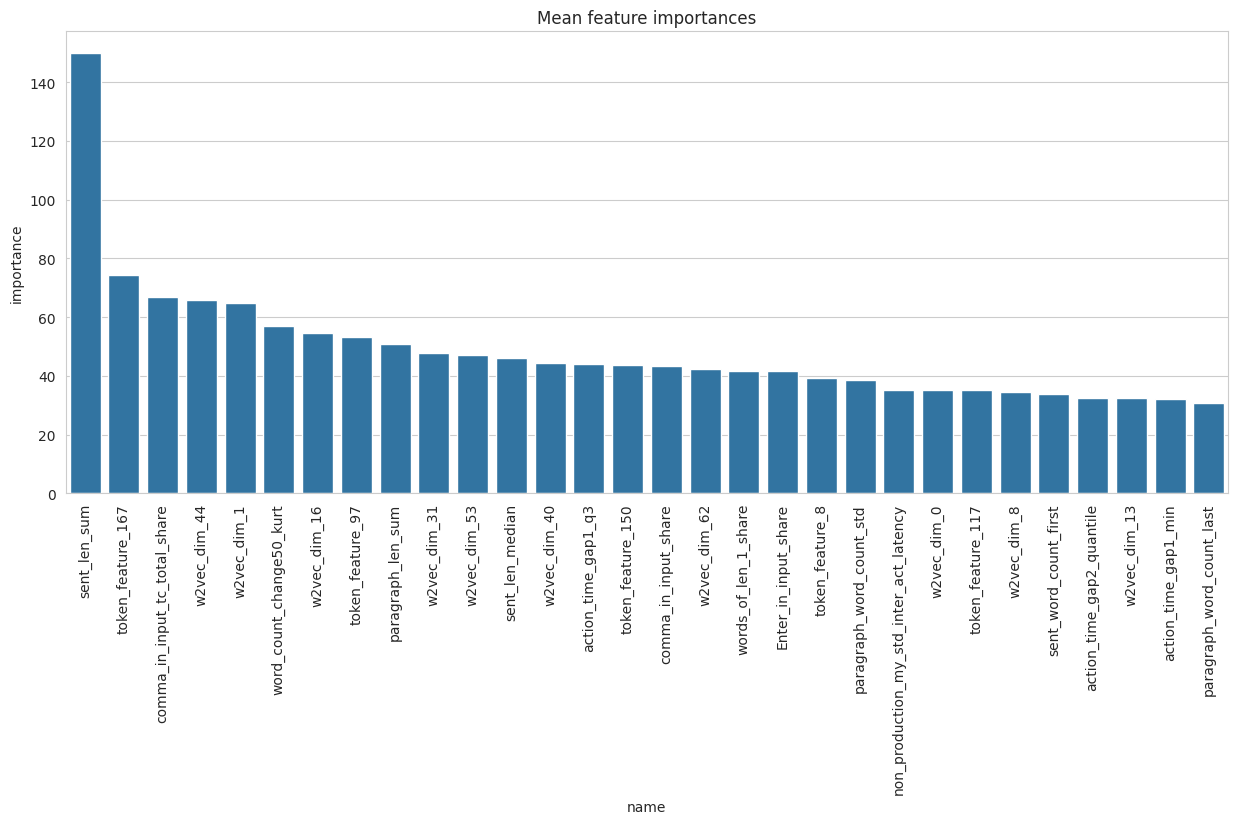

In [50]:
plt.figure(figsize=(15, 6))

ax = sns.barplot(data=feature_importance_df.head(30), x="name", y="importance")
ax.set_title(f"Mean feature importances")
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=90)

plt.show()

# Predicting The Test Set

We use the mean of all the predictions for all the fold models

In [69]:
# test_predict_list

In [70]:
test_feats["score"] = np.mean(test_predict_list, axis=0)

In [71]:
test_feats[["id", "score"]].to_csv("submission.csv", index=False)